In [4]:
require("Rsamtools")
require("Hmisc")
require("dplyr")
require("ggplot2")
require("stringi")
require("stats")
require("Biostrings")
require("reshape2")
require("viridis")
require("seqinr")
require("stringr")

In [5]:
DB="EquAllRS"
fxG="../../output/04_fragmentomics/genus_level/"
db_dir="../../../make_database/"

In [6]:
file_list <- list.files(path = fxG, pattern = "R1.fastq")
if (exists("all_G")){rm("all_G")}
for (f in file_list[!grepl(file_list, pattern = "PC")]){
    if(grepl(f, pattern = paste0("_", DB,"_"))){
        fastq_tmp <- read.table(file = paste0(fxG, f), sep = "\n") 

        fastq_end_df <- data.frame(seq = fastq_tmp[seq(2, nrow(fastq_tmp), 4),]) %>% 
                    mutate(dn = substring(text = seq, 0, 2))  %>% 
                    group_by(dn) %>% 
                    summarise(count = n())

        fastq_tl <- dinucleotideFrequency(x = DNAStringSet(fastq_tmp[seq(2, nrow(fastq_tmp), 4),]), 
            step=1, as.prob=FALSE, as.matrix=FALSE, fast.moving.side="right", with.labels=TRUE) %>% 
            colSums() 
        
        fastq_tl_df <- data.frame(dn = names(fastq_tl), count_tile = fastq_tl)

        fastq_all_df <- merge(fastq_end_df, fastq_tl_df, by = "dn", all = TRUE) %>% 
                mutate(sample_id = unlist(strsplit(f, split = "_"))[1]) %>%  
                mutate(taxId = unlist(strsplit(f, split = "_"))[4]) %>% 
                mutate(count_tile = count_tile - count)

        if (!exists("all_G")){all_G <- fastq_all_df} else {all_G <- rbind(all_G, fastq_all_df)}
        rm("fastq_tmp"); rm("fastq_end_df"); rm("fastq_tl");rm("fastq_tl_df");rm("fastq_all_df")
    }
} 

insp_file <- read.csv(file = paste0(db_dir, DB, "_inspect.txt"), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
insp_file$V6 <-  str_trim(insp_file$V6, side = "left")
all_G$taxNm <- NA
for (txd in unique(all_G$taxId)){
    txd_names <- insp_file$V6[insp_file$V5 == txd] 
    all_G <- all_G %>% mutate(taxNm = ifelse(taxId == txd, yes = txd_names, no = taxNm)) 
}

`summarise()` has grouped output by 'dn', 'sample'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sn', 'sample'. You can override using the `.groups` argument.


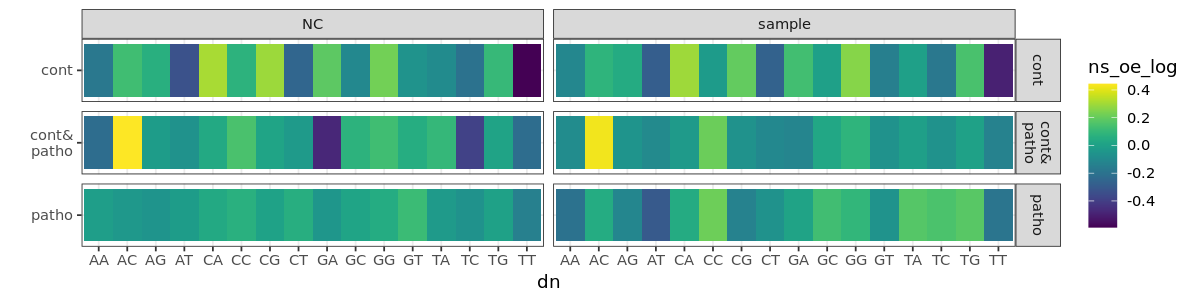

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.


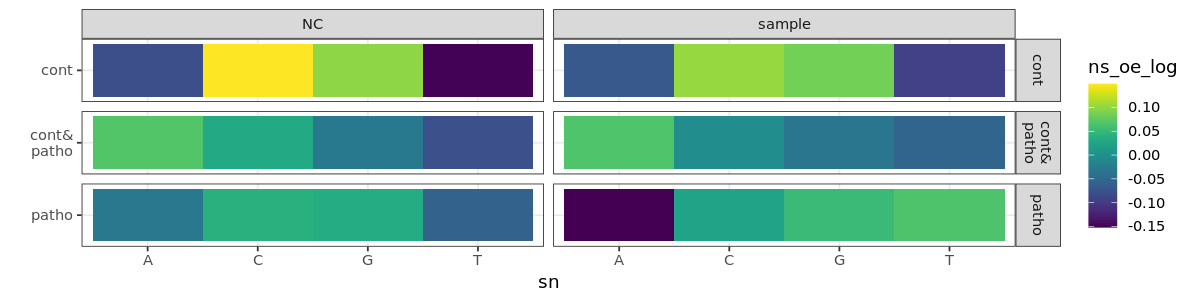

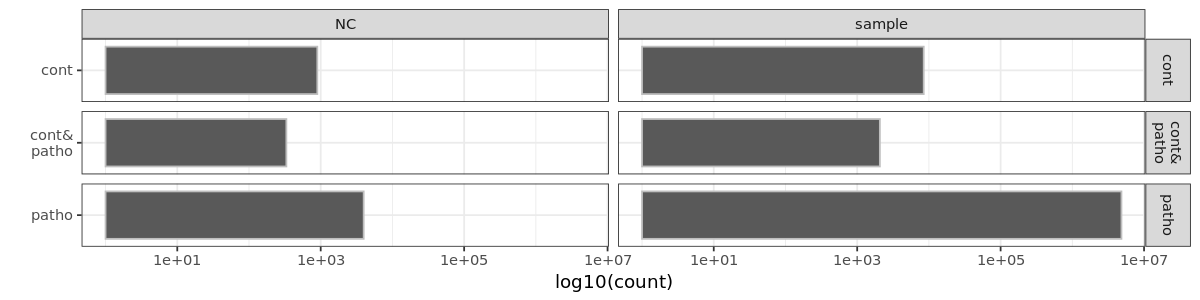

In [7]:
options(repr.plot.width=10, repr.plot.height=2.5)
all_G %>% 
    filter(taxNm %nin% c("Listeria", "Limosilactobacillus", "Lactobacillus", "Enterococcus", "Cryptococcus")) %>% 
    mutate(taxLbl = ifelse(taxNm %in% c("Verrucomicrobium", "Komagataella", "Plasmodium", "Saccharomyces", 
                                       "Ideonella", "Phnomibacter", "Cereibacter", "Microbacter"), yes = "cont", "patho")) %>%
    mutate(taxLbl = ifelse(taxNm %in% c("Staphylococcus", "Serratia"), yes = "cont&\npatho", taxLbl)) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    #filter(sample == "sample") %>% 
    filter(!grepl(dn, pattern = "N")) %>% 
    group_by(dn, sample, taxLbl) %>% 
    summarise(scount = sum(count, na.rm = TRUE), scount_tile = sum(count_tile, na.rm = TRUE)) %>% 
    group_by(sample, taxLbl) %>% 
    mutate(nscount = 100*scount/sum(scount)) %>%
    mutate(nscount_tile = 100*scount_tile/sum(scount_tile)) %>% 
    mutate(ns_oe = nscount/nscount_tile, ns_oe_log = log10(nscount/nscount_tile)) %>% 
    ggplot(aes(x = dn, y = taxLbl, fill = ns_oe_log)) + 
        geom_tile() + scale_fill_viridis(na.value="white") + #scale_fill_gradientn(colours = c("yellow", "darkgreen", "blue")) + 
        facet_grid(cols = vars(sample), rows = vars(taxLbl), scales = "free", space = "free") + 
        theme_bw() + ylab("") 

all_G %>% 
    filter(taxNm %nin% c("Listeria", "Limosilactobacillus", "Lactobacillus", "Enterococcus", "Cryptococcus")) %>% 
    mutate(taxLbl = ifelse(taxNm %in% c("Verrucomicrobium", "Komagataella", "Plasmodium", "Saccharomyces", 
                                       "Ideonella", "Phnomibacter", "Cereibacter", "Microbacter"), yes = "cont", "patho")) %>%
    mutate(taxLbl = ifelse(taxNm %in% c("Staphylococcus", "Serratia"), yes = "cont&\npatho", taxLbl)) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    #filter(sample == "sample") %>% 
    mutate(sn = substring(text = dn, 0, 1)) %>% 
    filter(!grepl(sn, pattern = "N")) %>% 
    group_by(sn, sample, taxLbl) %>% 
    summarise(scount = sum(count, na.rm = TRUE), scount_tile = sum(count_tile, na.rm = TRUE)) %>% 
    group_by(sample, taxLbl) %>% 
    mutate(nscount = 100*scount/sum(scount)) %>%
    mutate(nscount_tile = 100*scount_tile/sum(scount_tile)) %>% 
    mutate(ns_oe = nscount/nscount_tile, ns_oe_log = log10(nscount/nscount_tile)) %>% 
    ggplot(aes(x = sn, y = taxLbl, fill = ns_oe_log)) + 
        geom_tile() + scale_fill_viridis(na.value="white") + #scale_fill_gradientn(colours = c("yellow", "darkgreen", "blue")) + 
        facet_grid(cols = vars(sample), rows = vars(taxLbl), scales = "free", space = "free") + 
        theme_bw() + ylab("") 


all_G %>% 
    filter(taxNm %nin% c("Listeria", "Limosilactobacillus", "Lactobacillus", "Enterococcus", "Cryptococcus")) %>% 
    mutate(taxLbl = ifelse(taxNm %in% c("Verrucomicrobium", "Komagataella", "Plasmodium", "Saccharomyces", 
                                       "Ideonella", "Phnomibacter", "Cereibacter", "Microbacter"), yes = "cont", "patho")) %>%
    mutate(taxLbl = ifelse(taxNm %in% c("Staphylococcus", "Serratia"), yes = "cont&\npatho", taxLbl)) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    #filter(sample == "sample") %>% 
    filter(!grepl(dn, pattern = "N")) %>% 
    group_by(sample, taxLbl) %>% 
    summarise(scount = sum(count, na.rm = TRUE), scount_tile = sum(count_tile, na.rm = TRUE))  %>% 
    ggplot(aes(x = scount, y = taxLbl)) + 
        geom_bar(position = "dodge", stat = "identity", col = "grey") + 
        facet_grid(cols = vars(sample), rows = vars(taxLbl), scales = "free_y", space = "free") + 
        scale_x_continuous(trans='log10') + xlab("log10(count)") +
        theme_bw() + ylab("")

`summarise()` has grouped output by 'sn', 'taxNm', 'sample'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'taxNm', 'sample'. You can override using the `.groups` argument.


ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `sum()`.
[36mℹ[39m In group 1: `taxNm = "Acinetobacter"`, `sample = "NC"`.
[1mCaused by error:[22m
[1m[22m[33m![39m `..1` must be a logical vector, not the number 0.


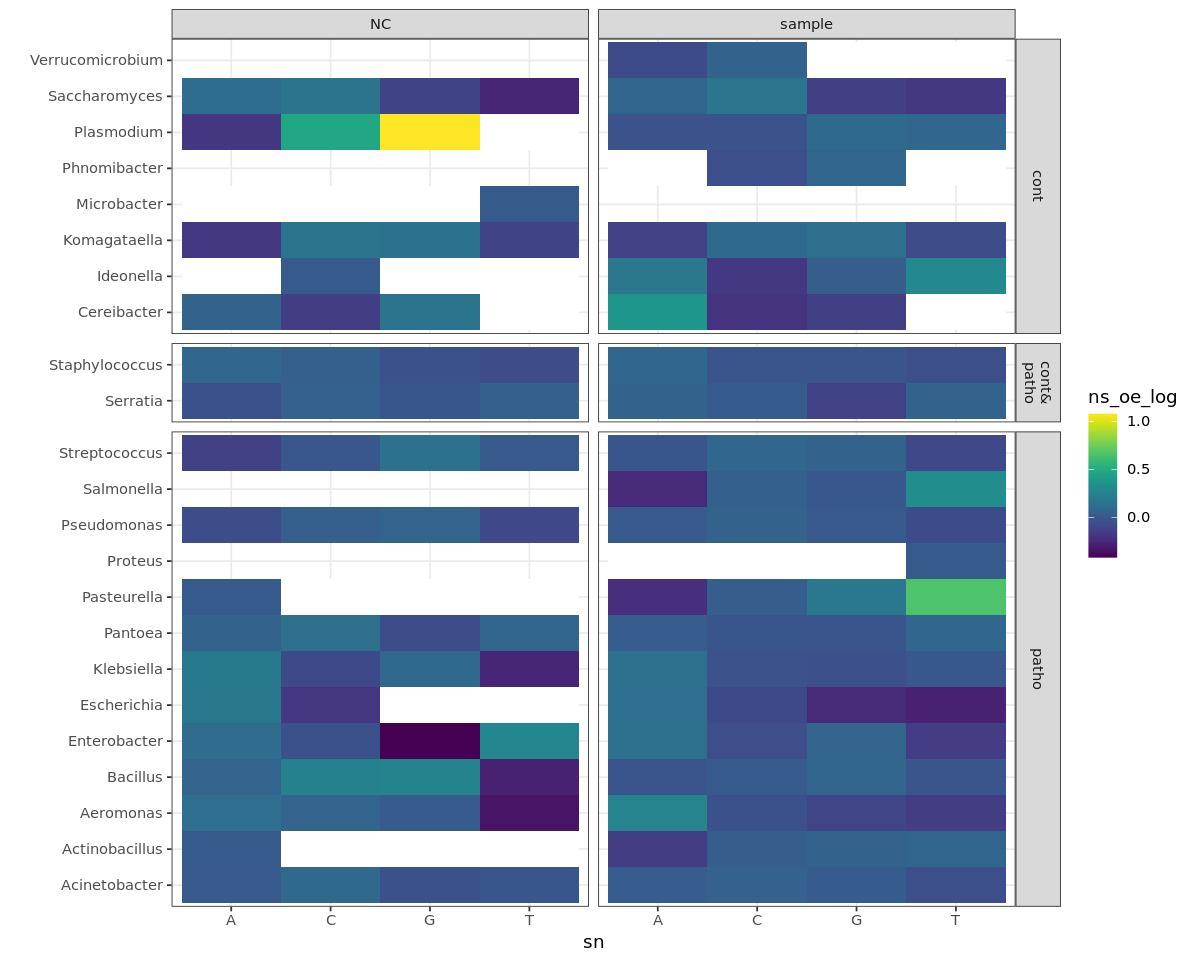

In [8]:
options(repr.plot.width=7, repr.plot.height=4)
options(repr.plot.width=10, repr.plot.height=8)
all_G %>% 
    filter(taxNm %nin% c("Listeria", "Limosilactobacillus", "Lactobacillus", "Enterococcus", "Cryptococcus")) %>% 
    mutate(taxLbl = ifelse(taxNm %in% c("Verrucomicrobium", "Komagataella", "Plasmodium", "Saccharomyces", 
                                       "Ideonella", "Phnomibacter", "Cereibacter", "Microbacter"), yes = "cont", "patho")) %>%
    mutate(taxLbl = ifelse(taxNm %in% c("Staphylococcus", "Serratia"), yes = "cont&\npatho", taxLbl)) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    #filter(sample == "sample") %>% 
    mutate(sn = substring(text = dn, 0, 1)) %>% 
    filter(!grepl(sn, pattern = "N")) %>% 
    group_by(sn, taxNm, sample, taxLbl) %>% 
    summarise(scount = sum(count, na.rm = TRUE), scount_tile = sum(count_tile, na.rm = TRUE)) %>% 
    group_by(taxNm, sample, taxLbl) %>% 
    mutate(nscount = 100*scount/sum(scount)) %>%
    mutate(nscount_tile = 100*scount_tile/sum(scount_tile)) %>% 
    mutate(ns_oe = nscount/nscount_tile, ns_oe_log = log10(nscount/nscount_tile)) %>% 
    ggplot(aes(x = sn, y = taxNm, fill = ns_oe_log)) + 
        geom_tile() + scale_fill_viridis(na.value="white") + #scale_fill_gradientn(colours = c("yellow", "darkgreen", "blue")) + 
        facet_grid(cols = vars(sample), rows = vars(taxLbl), scales = "free", space = "free") + 
        theme_bw() + ylab("") 

all_G %>% 
    filter(taxNm %nin% c("Listeria", "Limosilactobacillus", "Lactobacillus", "Enterococcus", "Cryptococcus")) %>% 
    mutate(taxLbl = ifelse(taxNm %in% c("Verrucomicrobium", "Komagataella", "Plasmodium", "Saccharomyces", 
                                       "Ideonella", "Phnomibacter", "Cereibacter", "Microbacter"), yes = "cont", "patho")) %>%
    mutate(taxLbl = ifelse(taxNm %in% c("Staphylococcus", "Serratia"), yes = "cont&\npatho", taxLbl)) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    #filter(sample == "sample") %>% 
    filter(!grepl(dn, pattern = "N")) %>% 
    group_by(taxNm, sample, taxLbl) %>% 
    summarise(scount = sum(count, na.rm = TRUE), scount_tile = sum(count_tile, na.rm = TRUE))  %>% 
    filter(sum())
    ggplot(aes(x = scount, y = taxNm)) + 
        geom_bar(position = "dodge", stat = "identity", col = "grey") + 
        facet_grid(cols = vars(sample), rows = vars(taxLbl), scales = "free_y", space = "free") + 
        scale_x_continuous(trans='log10') + xlab("log10(count)") +
        theme_bw() + ylab("")

In [ ]:
CID_meta <- read.csv(file = "/home/cog/ewesdorp/tmp_meta_foals.csv", sep = "\t")
all_G$CID <- NA
for (ptID in CID_meta$patientID){
    all_G$CID[all_G$sample_id == ptID] <- CID_meta$CID[CID_meta$patientID == ptID]
}

In [ ]:
options(repr.plot.width=7, repr.plot.height=2.5)
all_G %>% 
    filter(taxNm %nin% c("Listeria", "Limosilactobacillus", "Lactobacillus", "Enterococcus", "Cryptococcus")) %>% 
    mutate(taxLbl = ifelse(taxNm %in% c("Verrucomicrobium", "Komagataella", "Plasmodium", "Saccharomyces", 
                                       "Ideonella", "Phnomibacter", "Cereibacter", "Microbacter"), yes = "cont", "patho")) %>%
    mutate(taxLbl = ifelse(taxNm %in% c("Staphylococcus", "Serratia"), yes = "cont&\npatho", taxLbl)) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    filter(sample == "sample") %>% 
    filter(taxLbl == "patho") %>% 
    filter(!grepl(dn, pattern = "N")) %>% 
    filter(!grepl(CID, pattern = "NSCP")) %>% 
    mutate(CID_sh = substring(text = CID, 0, 1)) %>% 
    group_by(dn, CID_sh, sample) %>% 
    summarise(scount = sum(count, na.rm = TRUE), scount_tile = sum(count_tile, na.rm = TRUE)) %>% 
    group_by(CID_sh, sample) %>% 
    mutate(nscount = 100*scount/sum(scount)) %>%
    mutate(nscount_tile = 100*scount_tile/sum(scount_tile)) %>% 
    mutate(ns_oe = nscount/nscount_tile, ns_oe_log = log10(nscount/nscount_tile)) %>% 
    ggplot(aes(x = dn, y = CID_sh, fill = ns_oe_log)) + 
        geom_tile() + scale_fill_viridis(na.value="white") + #scale_fill_gradientn(colours = c("yellow", "darkgreen", "blue")) + 
        facet_grid(cols = vars(sample), rows = vars(CID_sh), scales = "free", space = "free") + 
        theme_bw() + ylab("") 

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
all_G %>% 
    filter(taxNm %nin% c("Listeria", "Limosilactobacillus", "Lactobacillus", "Enterococcus", "Cryptococcus")) %>% 
    mutate(taxLbl = ifelse(taxNm %in% c("Verrucomicrobium", "Komagataella", "Plasmodium", "Saccharomyces", 
                                       "Ideonella", "Phnomibacter", "Cereibacter", "Microbacter"), yes = "cont", "patho")) %>%
    mutate(taxLbl = ifelse(taxNm %in% c("Staphylococcus", "Serratia"), yes = "cont&\npatho", taxLbl)) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    filter(sample == "sample") %>% 
    filter(taxLbl == "patho") %>% 
    filter(!grepl(dn, pattern = "N")) %>% 
    filter(!grepl(CID, pattern = "NSCP")) %>% 
    mutate(CID_sh = substring(text = CID, 0, 1)) %>% 
    group_by(dn, CID, CID_sh, taxId) %>% 
    summarise(scount = sum(count, na.rm = TRUE), scount_tile = sum(count_tile, na.rm = TRUE)) %>% 
    group_by(CID, CID_sh, taxId) %>% 
    mutate(nscount = 100*scount/sum(scount)) %>%
    mutate(nscount_tile = 100*scount_tile/sum(scount_tile)) %>% 
    mutate(ns_oe = nscount/nscount_tile, ns_oe_log = log10(nscount/nscount_tile)) %>% #head()
    filter(dn %in% c("GG", "CC")) %>% 
    #filter()
    ggplot(aes(y = taxId, x = CID, fill = ns_oe)) + 
        geom_tile() + scale_fill_viridis(na.value="white") + #scale_fill_gradientn(colours = c("yellow", "darkgreen", "blue")) + 
        facet_grid(cols = vars(CID_sh), rows = vars(dn), scales = "free", space = "free") + 
        theme_bw() + ylab("") + theme(axis.text.x = element_text(angle = 90)) + ggtitle("CC-ends")

In [ ]:
all_G %>% 
    filter(taxNm %nin% c("Listeria", "Limosilactobacillus", "Lactobacillus", "Enterococcus", "Cryptococcus")) %>% 
    mutate(taxLbl = ifelse(taxNm %in% c("Verrucomicrobium", "Komagataella", "Plasmodium", "Saccharomyces", 
                                       "Ideonella", "Phnomibacter", "Cereibacter", "Microbacter"), yes = "cont", "patho")) %>%
    mutate(taxLbl = ifelse(taxNm %in% c("Staphylococcus", "Serratia"), yes = "cont&\npatho", taxLbl)) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    #filter(sample == "sample") %>% 
    filter(!grepl(dn, pattern = "N")) %>% 
    group_by(dn, taxNm, sample, taxLbl) %>% 
    summarise(scount = sum(count, na.rm = TRUE), scount_tile = sum(count_tile, na.rm = TRUE)) %>% 
    group_by(taxNm, sample, taxLbl) %>% 
    mutate(nscount = 100*scount/sum(scount)) %>%
    mutate(nscount_tile = 100*scount_tile/sum(scount_tile)) %>% 
    mutate(ns_oe = nscount/nscount_tile, ns_oe_log = log10(nscount/nscount_tile)) %>% 
    filter(dn %in% c("CC", "GG")) %>% 
    ggplot(aes(x = ns_oe, y = taxNm, col = sample, shape = dn)) + 
        geom_point() + xlim(-0.2,6) + 
        facet_grid(cols = vars(sample), rows = vars(taxLbl), scales = "free_y", space = "free") + 
        geom_vline(xintercept = 1, col = "grey")